<br>
<p style="font-size: 45px;
          text-align:center;
          font-family: 'Times New Roman';
          font-variant: small-caps;
          font-weight: bold;
          line-height: 50px;"> Laboratorio II Procesamiento de señales</p>
          
<p style="font-size: 20px;
text-align:center;
font-family: 'Times New Roman';
font-variant: small-caps;
font-weight: italic;
line-height: 50px;">Procesamiento de Señales Biomédicas</p>
<p style="font-size: 20px;
text-align:center;
font-family: 'Times New Roman';
font-variant: small-caps;
font-weight: italic;
line-height: 30px;">Clasificacion (inteligente) de patrones </p>
<br>


<br>
<div style="text-align: justify;width:80%;margin: 0 auto"> 
    
Para realizar la clasificación inteligente de patrones se tomará la base de datos de los puntos anteriores de este laboratorio, para tres condiciones distintas de los pacientes:
<br><br>
<li> Paciente sentado:  -1
    
<li> Paciente caminando: 0
    
<li>Paciente corriendo:  1
<br>
    
Se presenta adicionalmente el label encoder para cada una de las condiciones de los pacientes a considerar en este proceso de reconocimiento de patrones
    
El primer paso para realizar la clasificación requerida es la adquisición de señales, estas se tienen para 22 pacientes en las tres condiciones mencionadas anteriormente, sin embargo, de estas bases de datos se requiere seleccionar que señales van a ser utilizadas dentro del proceso de clasificación. Intuitivamente es esperable que al aumentar la actividad física la frecuencia cardiaca debe verse modificada significativamente, pues un paciente en estado de reposo tiene un comportamiento significativamente distinto al de un paciente realizando actividad física, por lo anterior, se utilizará la señal del electrocardiograma (ECG) como señal principal para la clasificaión de patrones. Posteriormente, dado que se cuenta con la aceleración de cada paciente también se seleccionará esta señal para realizar la clasificación. Si bien se cuenta con muchos otros datos, la estrategia a utilizar es iniciar con pocas señales y a medida que se obtengan resultados se irá aumentado la cantidad de datos de entrada al algoritmo para mejorar la clasificación inteligente de las señales.
    
Una vez se tienen definidas las señales a utilizar dentro del proceso a diseñar, se procede con el proceso de extracción de características. En la literatura se proponen diferentes opciones como valores promedios, frecuencia, o potencia. En este laboratorio se explorará la opción de utilizar los modos de correlación de Wavelet.
    
<br>
<div style="text-align: justify;width:80%;margin: 0 auto"> 
    
    
<br>
<p style="font-size: 20px;
text-align:center;
font-family: 'Times New Roman';
font-variant: small-caps;
font-weight: italic;
line-height: 30px;">Señales a utilizar </p>
<br>

In [27]:
from pathlib import Path
import pandas as pd 
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
from utils import get_data,display_signal,plot_signal,plot_coeffs,get_wavelet_correlation_modes

df = get_data(subject="s10",activity="run")

In [28]:
plt.rcParams["figure.figsize"] = (20,3)
interact(display_signal, t_inicial=widgets.IntSlider(min=0,max=400,step=1,value=300),signal=df.columns[1:]);

interactive(children=(IntSlider(value=300, description='t_inicial', max=400), Dropdown(description='signal', o…

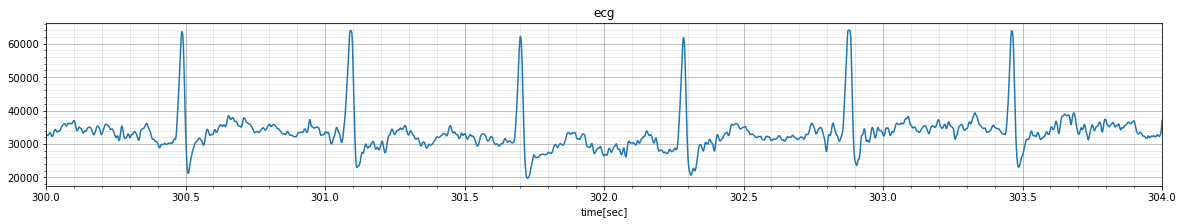

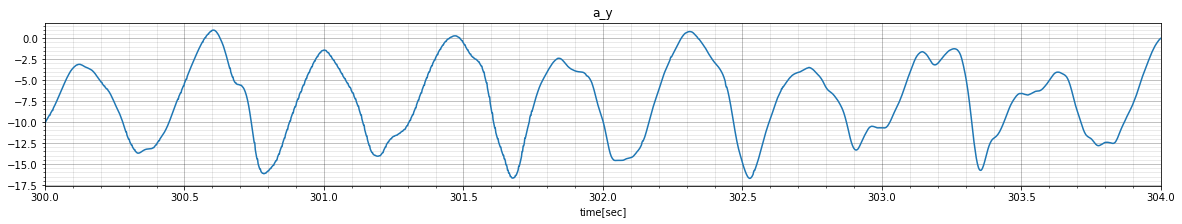

In [29]:
display_signal(t_inicial=300,signal="ecg")
display_signal(t_inicial=300,signal="a_y")

<br>
<p style="font-size: 20px;
text-align:center;
font-family: 'Times New Roman';
font-variant: small-caps;
font-weight: italic;
line-height: 30px;">Modos de Correlación Wavelet </p>
<br>
Para este proceso se realizará un ejemplo con la señal:

$$ x(t)= \left\{ 
                \begin{array}{lcc}
                cos(2 \pi \cdot 5\cdot t) & si & t \leq 2 \\\\
                0 & si & 2 < t \leq 4  \\\\ 
                cos(2 \pi \cdot 10\cdot t) & si & 4 < t \leq 6 \\\\
                0 & si & 6 < t \leq 8  \\\\
                cos(2 \pi \cdot 5\cdot t) & si & 8 < t \leq 10
                \end{array}
        \right.
$$

Muestreada a 100 [Hz], es decir, con un período de muestreo de 0.01 [sec]

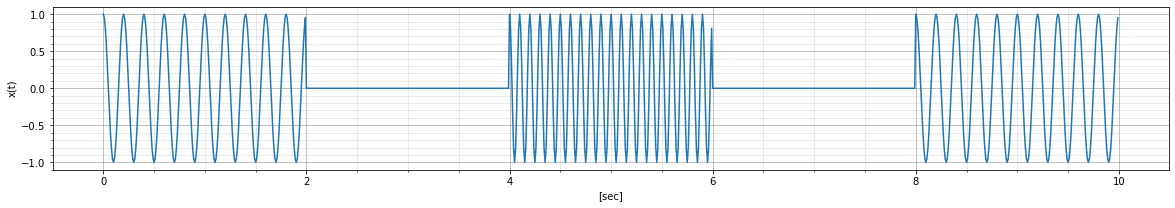

In [30]:
t=np.arange(0,2,0.01)
x=np.concatenate([
    np.cos(2*np.pi*5*t),
    np.zeros(len(t)),
    np.cos(2*np.pi*10*t),
    np.zeros(len(t)),
    np.cos(2*np.pi*5*t)])
plot_signal(np.arange(0,len(x))*0.01,x)
plt.xlabel("[sec]");
plt.ylabel("x(t)");

Se procede a realizar la transformada de Wavelet, para ello se implementa la librería:

``` python
from pywt import wavedec
```
Esta función wavedec permite hacer la descomposición tiempo vs frecuencia mediante la transformada de wavelet

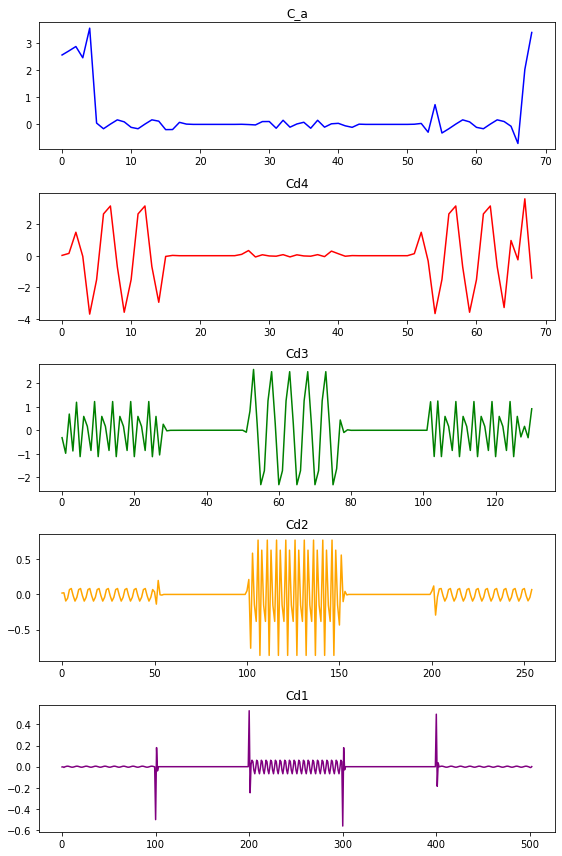

In [5]:
from pywt import wavedec
coeffs = wavedec(x, 'db4', level=4)
plot_coeffs(coeffs)

Una vez se tienen los vectores de detalle de la señal $x[n]$, se procede a realizar el proceso de upsampling y se encuentran los modos de correlación

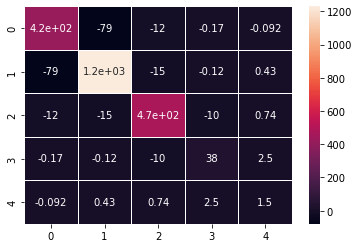

In [6]:
import scipy.signal as sg
import seaborn as sns

coeffs=np.array([sg.resample(coeff,500) for coeff in coeffs])
corr=coeffs@coeffs.T
ax = sns.heatmap(corr, linewidth=0.5,annot=True)
plt.show()

<p style="font-size: 20px;
text-align:center;
font-family: 'Times New Roman';
font-variant: small-caps;
font-weight: italic;
line-height: 50px;"> Pipeline Extracción de Características </p>
<br>

Se crea la función "get_wavelet_correlation_modes", la cual realiza todos los procesos descritos anteriormente para una señal x. Se agrega el parámetro plot para visualizar los pasos de forma individual, en caso de que dicha exploración sea requerida. Por ejemplo, para la señal x[n] de ejemplo se tiene:

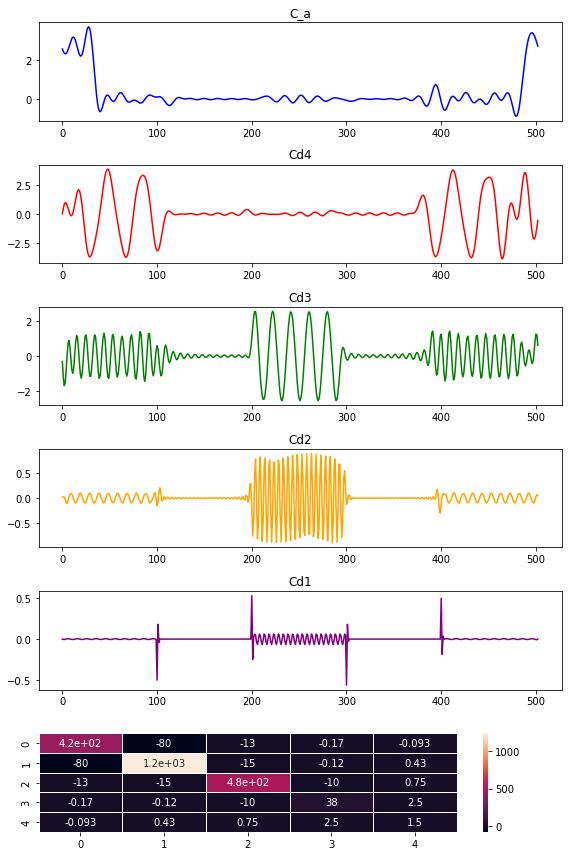

In [7]:
_ = get_wavelet_correlation_modes(x,plot=True)

Mientras que, para la señal del electrocardiograma se tiene el siguiente comportamiento. Notar que la señal fue escalada con una razón 100 000:1 para evitar valores de alta magnitud en la matriz de los modos de correlación

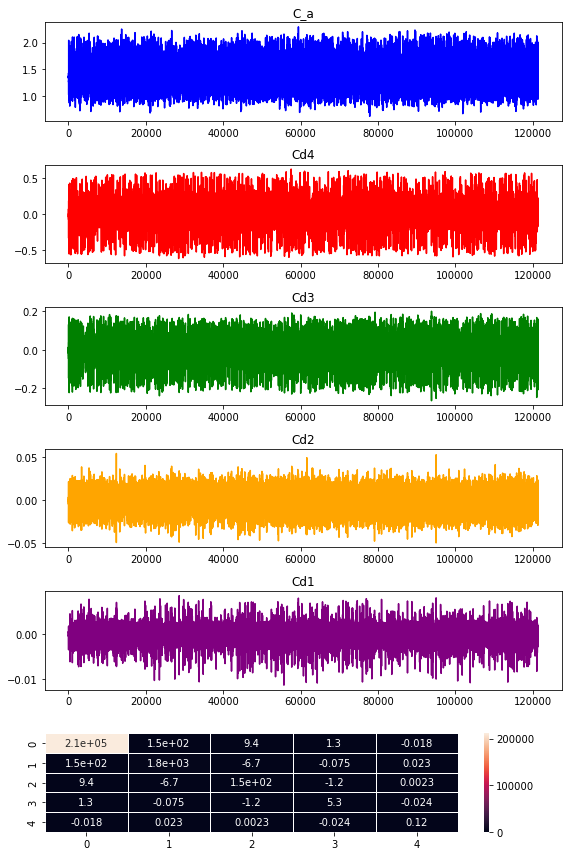

In [8]:
_=get_wavelet_correlation_modes(df["ecg"]/100_000,plot=True)

Dado que se tienen las componentes de la señal de aceleración en los ejes "x" "y" y "z", se procede a realizar el cálculo de la aceleración total mediante la ecuación


$$ a_T=\sqrt{a_x^2+a_y^2+a_z^2} $$

In [9]:
def get_total_acc(df):
    acc=np.sqrt(df["a_x"]**2+df["a_y"]**2+df["a_z"]**2)
    return acc

Dado que ya se tiene el pipeline de extracción de características automatizado, se procede a realizar el cálculo para todos los datos disponibles en la base de datos, y se hace la respectiva etiqueta mediante el label encoder presentado al inicio de esta sección

In [10]:
def extract_features():
    cwd=Path.cwd()
    
    DATA_DIR=cwd/"data"
    out={}
    out_y={}
    activity_dict={"run":1,"walk":0,"sit":-1}
    for subject in [f"s{x}" for x in range(1,23)]:
        for activity in ["walk","run","sit"]:
            df=pd.read_csv(DATA_DIR/f"{subject}_{activity}.csv")
            corr1=get_wavelet_correlation_modes(df["ecg"],plot=False)
            
            corr2=get_wavelet_correlation_modes(get_total_acc(df),plot=False)
            
            corr_out = np.hstack((
                np.reshape(corr1, -1, order='C'),
                np.reshape(corr2, -1, order='C')
            ))
            
            out[f"{subject}_{activity}"]=corr_out
            
            out_y[f"{subject}_{activity}"]=activity_dict[activity]
    return out,out_y

In [11]:
out_x,out_y = extract_features()

<br>
<div style="text-align: justify;width:80%;margin: 0 auto"> 
Finalmente, con el fin de manejar trazabilidad en el código, se almacenan las características y las etiquetas en dataframes de pandas, y se guardan en un dataframe, de dimensiones 66x51, notar que se tiene 66 filas dado que para 22 pacientes se tomaron 3 datos, corriendo, caminando y corriendo. Mientras que, para las columnas se tienen 51 componentes, la primer columna corresponde al resultado del label encoder, es decir, la salida esperada del algoritmo, por otro lado, para la señal del electrocardiagrama se tienen 25 componentes y para la aceleración las 25 componentes restantes, notar que para cada una de estas señales se tiene 25 componentes dado que la matrix de los modos de correlacción wavelet es una matriz 5x5
</div>
<br>

In [12]:
df_x=pd.DataFrame.from_dict(out_x,orient="index")
df_y=pd.DataFrame.from_dict(out_y,orient="index",columns=["out"])
df_wcm=pd.merge(df_y, df_x, left_index=True, right_index=True)
df_wcm.head()

,out,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
s1_walk,0,2.179986e+15,1.905237e+12,-2.831943e+10,-7.303060e+09,1.629147e+09,1.905237e+12,1.864201e+13,-7.304170e+10,2.271112e+09,...,54.281292,-0.600158,16.943849,153.448418,-0.559675,-75.163158,3.766907,3.761390,-0.559675,34.206614
s1_run,1,2.179092e+15,1.248652e+12,-1.054884e+10,-1.308035e+09,2.362983e+08,1.248652e+12,8.878139e+12,-2.748327e+10,1.118775e+09,...,3.630570,1.785354,0.473559,25.727849,-0.265112,45.784504,0.671264,0.043021,-0.265112,12.246175
s1_sit,-1,2.207753e+15,2.341106e+12,-9.443643e+10,4.726048e+09,-5.936800e+08,2.341106e+12,1.217801e+13,-2.281836e+10,3.334957e+09,...,162.738631,-0.110034,-0.086526,13.363207,-0.040033,13.103473,0.011059,0.023274,-0.040033,2.279198
s2_walk,0,2.143277e+15,-1.456463e+12,-5.404886e+10,5.849392e+09,-6.123772e+08,-1.456463e+12,1.713866e+13,-1.171165e+09,-1.499891e+09,...,-59.549483,1.825905,-1.033436,13.891925,-0.159253,79.503014,-0.003951,0.099601,-0.159253,4.990381
s2_run,1,2.206401e+15,9.383945e+11,1.464615e+10,-1.587223e+10,1.587847e+08,9.383945e+11,2.137980e+13,-2.474058e+10,6.038491e+08,...,-766.434915,-7.774031,-7.357334,73.454563,0.374393,-175.770850,0.191935,-0.892587,0.374393,52.996952


In [13]:
# df_wcm.to_csv("wcm.csv")

En el paso anterior se almacenaron las características extraídas del WCM en el archivo wcm.csv. Ahora se procede a abrir dicho archivo a realizar la separación de variables entre entradas (X) y salidas (y)

In [14]:
df_wcm=pd.read_csv("wcm.csv")
df_y,df_x=df_wcm["out"],df_wcm.iloc[:,2:]
#df_x

Dado que las características tienen una magnitud apreciable, se procede a realizar una estandarización de magnitudes con valor promedio 0 y con desviación estandar igual 1, utilizando la librería de Sklearn Standard Scaler

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_x_t=scaler.fit_transform(df_x)
#df_x_t

<p style="font-size: 20px;
text-align:center;
font-family: 'Times New Roman';
font-variant: small-caps;
font-weight: italic;
line-height: 50px;"> Reducción de dimensionalidad </p>
<br>

Dado que se tienen 50 descriptores de cada dato registrado, se propone realizar una reducción de dimensionalidad por componentes principales (PCA)

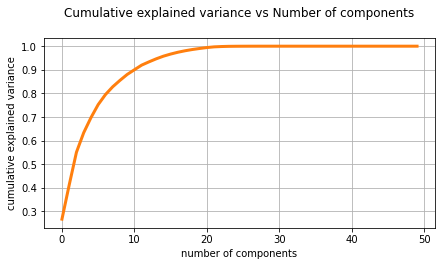

In [16]:
from sklearn.decomposition import PCA
pca = PCA().fit(df_x_t)

plt.figure(figsize=(7, 3.5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color="tab:orange", linewidth=3)
plt.xlabel("number of components")
plt.ylabel("cumulative explained variance")
plt.title("Cumulative explained variance vs Number of components\n")
plt.grid()
plt.show()


In [17]:
df_x_t_pca = PCA(n_components=25).fit_transform(df_x_t)
#df_x_t_pca

In [18]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
y= df_y.values.ravel()
X=df_x_t_pca
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

<p style="font-size: 20px;
text-align:center;
font-family: 'Times New Roman';
font-variant: small-caps;
font-weight: italic;
line-height: 50px;"> Validación del desempeño </p>
<br>

Para hacer la validación del desempeño del clasificador implementado, inicialmente se extraen los resultados obtenidos por el clasificador mediante el método predict

In [25]:
y_pred=clf.predict(X)
y,y_pred

(array([ 0,  1, -1,  0,  1, -1,  0,  1, -1,  0,  1, -1,  0,  1, -1,  0,  1,
        -1,  0,  1, -1,  0,  1, -1,  0,  1, -1,  0,  1, -1,  0,  1, -1,  0,
         1, -1,  0,  1, -1,  0,  1, -1,  0,  1, -1,  0,  1, -1,  0,  1, -1,
         0,  1, -1,  0,  1, -1,  0,  1, -1,  0,  1, -1,  0,  1, -1],
       dtype=int64),
 array([ 0,  1, -1,  0,  1, -1,  0,  1, -1,  0,  1, -1,  0,  1, -1,  0,  1,
        -1,  0,  1, -1,  0,  1, -1,  0,  1, -1,  0,  1, -1,  0,  1, -1,  0,
         1, -1,  0,  1, -1,  0,  1, -1,  0,  1, -1,  0,  1, -1,  0,  1, -1,
         0,  1, -1,  0,  1, -1,  0,  1, -1,  0,  1, -1,  0,  1, -1],
       dtype=int64))

Si bien se pueden comparar uno a uno los resultados esperados contra los resultados obtenidos, la mejor forma de realizar la validación del clasificador es mediante una matriz de confusión, está indica para una etiquete real cual fue el valor obtenido por el modelo


In [20]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y, y_pred)
cm

array([[22,  0,  0],
       [ 0, 22,  0],
       [ 0,  0, 22]], dtype=int64)

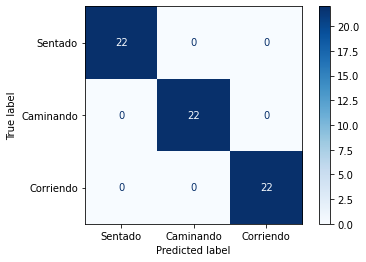

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Sentado","Caminando","Corriendo"],
)
disp.plot(cmap=plt.cm.Blues);

Adicionalmente, para medir el desempeño del modelo existen otras métricas descritas en https://scikit-learn.org/stable/modules/model_evaluation.html

In [22]:
from sklearn import metrics
evaluation_metrics={
    "accuracy":metrics.accuracy_score,
    "balanced_accuracy":metrics.balanced_accuracy_score
}

for name,fun in evaluation_metrics.items():
    print(f"{name} = {fun(y,y_pred)}")

accuracy = 1.0
balanced_accuracy = 1.0


In [23]:
from sklearn.metrics import classification_report
print(classification_report(
    y, y_pred, 
    target_names=["Sentado","Caminando","Corriendo"]
))

              precision    recall  f1-score   support

     Sentado       1.00      1.00      1.00        22
   Caminando       1.00      1.00      1.00        22
   Corriendo       1.00      1.00      1.00        22

    accuracy                           1.00        66
   macro avg       1.00      1.00      1.00        66
weighted avg       1.00      1.00      1.00        66



El resultado si solo se utilizara la señal del electrocardiograma, es decir, sin la aceleración es:

              precision    recall  f1-score   support

     Sentado       0.81      0.95      0.88        22
   Caminando       0.86      0.82      0.84        22
   Corriendo       0.95      0.82      0.88        22

    accuracy                           0.86        66
   macro avg       0.87      0.86      0.86        66
weighted avg       0.87      0.86      0.86        66



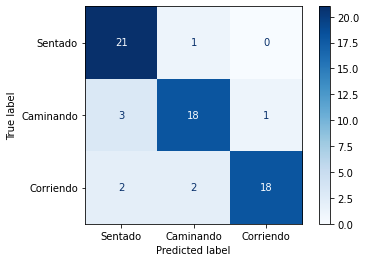

In [24]:
from utils import classifier_only_ecg
classifier_only_ecg(df_wcm)

# Referencias 

<br>
<div style="text-align: justify;width:90%;margin: 0 auto"> 
    
    [1]. Mehrgardt, P., Khushi, M., Poon, S., & Withana, A. (2022). Pulse Transit Time PPG Dataset (version 1.1.0). PhysioNet. https://doi.org/10.13026/jpan-6n92. 

    [2] Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220..

    [3] Gregory R. Lee, Ralf Gommers, Filip Wasilewski, Kai Wohlfahrt, Aaron O’Leary (2019). PyWavelets: A Python package for wavelet analysis. Journal of Open Source Software, 4(36), 1237, https://doi.org/10.21105/joss.01237.
    
    [4] Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.
    
    [5] Cardona Posada, J. (2022). Detección y clasificación de fallas eléctricas en sistemas de distribución de energía eléctrica mediante el uso de la transformada wavelet continua y funciones madre de soporte infinito. [online] Medellín, Colombia: Universidad Nacional de Colombia. [Acceso : 6 de mayo 2024]

    [6]T. pandas development team, pandas-dev/pandas: Pandas. Zenodo, 2020. doi: 10.5281/zenodo.3509134.
    
    [7]Stéfan van der Walt, Ed., “ Data Structures for Statistical Computing in Python ,” in Proceedings of the 9th Python in Science Conference , 2010, pp. 56–61. doi: 10.25080/Majora-92bf1922-00a .
    
    [8]P. Virtanen et al., “SciPy 1.0: Fundamental Algorithms for Scientific Computing in Python,” Nature Methods, vol. 17, pp. 261–272, 2020, doi: 10.1038/s41592-019-0686-2.
    
    [9]J. D. Hunter, “Matplotlib: A 2D graphics environment,” Computing in Science & Engineering, vol. 9, no. 3, pp. 90–95, 2007, doi: 10.1109/MCSE.2007.55.
    
    [10]Waskom, M. L., (2021). seaborn: statistical data visualization. Journal of Open Source Software, 6(60), 3021, https://doi.org/10.21105/joss.03021.
</div>